# Load DF


Target Variable Distribution:
rated_binary
1    5460
0    3437
Name: count, dtype: int64
Training Target Class Distribution:
rated_binary
1    4368
0    2749
Name: count, dtype: int64
SVM Classification Metrics (Holdout Validation):
Accuracy: 0.86
Precision: 0.97
Recall: 0.80
F1 Score: 0.88
ROC AUC (Holdout Validation): 0.98


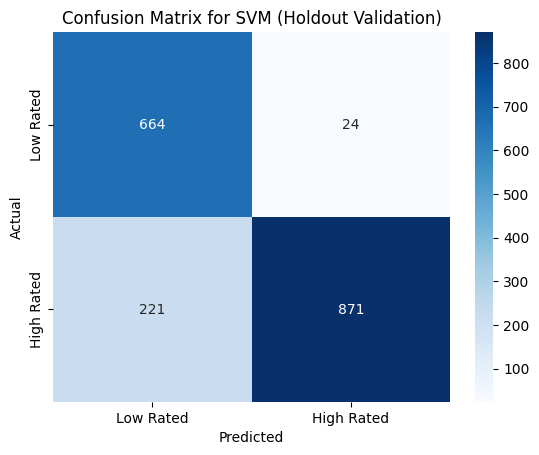

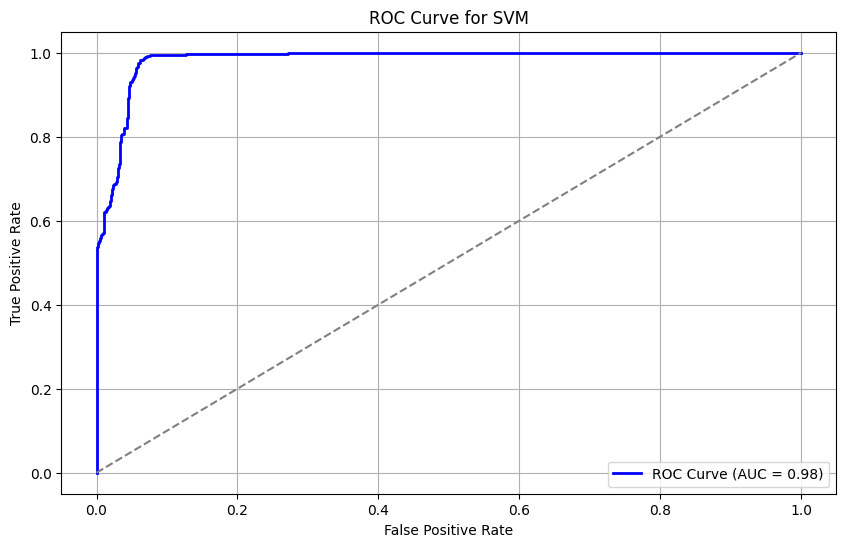


Cross-Validation Results (SVM):
Mean Cross-Validation Accuracy: 0.85
Standard Deviation of Cross-Validation Accuracy: 0.01
Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9633254242106011


In [34]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
audible_df = pd.read_csv('audible_output.csv')

# Preprocessing

# Drop rows with missing critical values
audible_df = audible_df.dropna(subset=['minutes', 'ratings', 'price_usd'])

# Convert columns to numeric types
audible_df['minutes'] = pd.to_numeric(audible_df['minutes'], errors='coerce')
audible_df['ratings'] = pd.to_numeric(audible_df['ratings'], errors='coerce')
audible_df['price_usd'] = pd.to_numeric(audible_df['price_usd'], errors='coerce')

# --- Define Target Variable ---

# Create binary classification target: Low-rated (0) vs High-rated (1)
audible_df['rated_binary'] = audible_df['ratings'].apply(lambda x: 1 if x > 3.25 else 0)

# Check the distribution of the target variable
print("Target Variable Distribution:")
print(audible_df['rated_binary'].value_counts())

# --- Feature Selection ---

# Select features for classification
X_svm = audible_df[['minutes', 'ratings', 'price_usd']]
y_svm = audible_df['rated_binary']

# Train-test split with stratification (Holdout Validation)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

# Check class balance in training data
print("Training Target Class Distribution:")
print(y_train_svm.value_counts())

# Standardize the features for SVM
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

# Train SVM Model using default hyperparameters
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# --- Evaluate SVM Model (Holdout Validation) ---

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_svm)

# Performance metrics
accuracy = accuracy_score(y_test_svm, y_pred_svm)
precision = precision_score(y_test_svm, y_pred_svm)
recall = recall_score(y_test_svm, y_pred_svm)
f1 = f1_score(y_test_svm, y_pred_svm)

print("SVM Classification Metrics (Holdout Validation):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# --- ROC Curve ---
# Calculate decision scores for the ROC curve
y_score_svm = svm_model.decision_function(X_test_svm)
fpr, tpr, _ = roc_curve(y_test_svm, y_score_svm)
roc_auc = roc_auc_score(y_test_svm, y_score_svm)

print(f"ROC AUC (Holdout Validation): {roc_auc:.2f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Rated', 'High Rated'], yticklabels=['Low Rated', 'High Rated'])
plt.title("Confusion Matrix for SVM (Holdout Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# --- Cross-Validation ---
# Perform cross-validation to evaluate the model
cv_scores = cross_val_score(svm_model, X_train_svm, y_train_svm, cv=5, scoring='accuracy')
cv_mean_accuracy = cv_scores.mean()
cv_std_accuracy = cv_scores.std()

print("\nCross-Validation Results (SVM):")
print(f"Mean Cross-Validation Accuracy: {cv_mean_accuracy:.2f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {cv_std_accuracy:.2f}")

# --- Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_svm, y_train_svm)

# Display best parameters and best score
print("Best Parameters for SVM:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


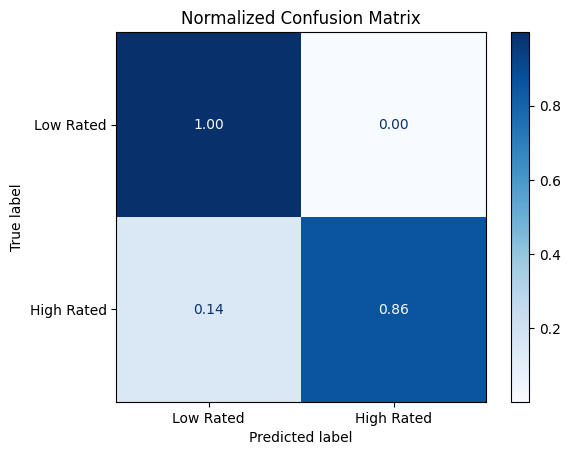

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the normalized confusion matrix
cm_normalized = confusion_matrix(y_test_svm, y_pred_svm, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Low Rated', 'High Rated'])
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()


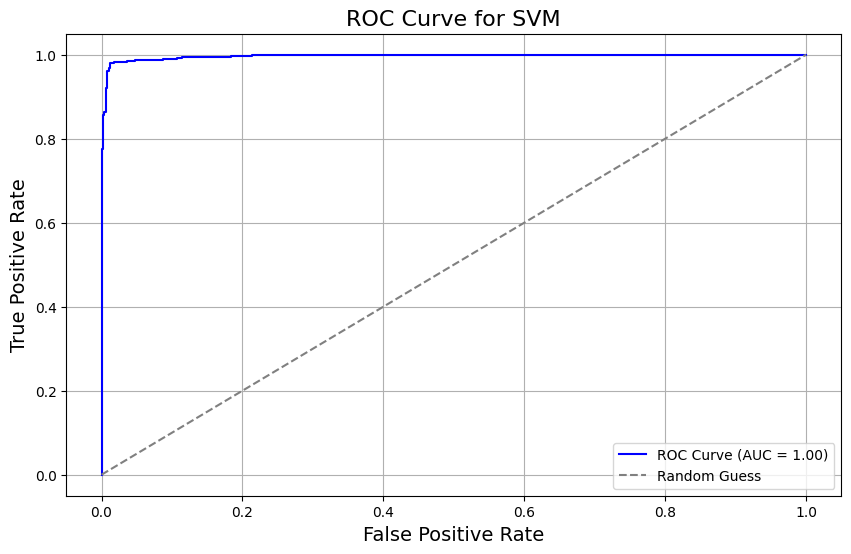

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve for SVM", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend()
plt.grid()
plt.show()


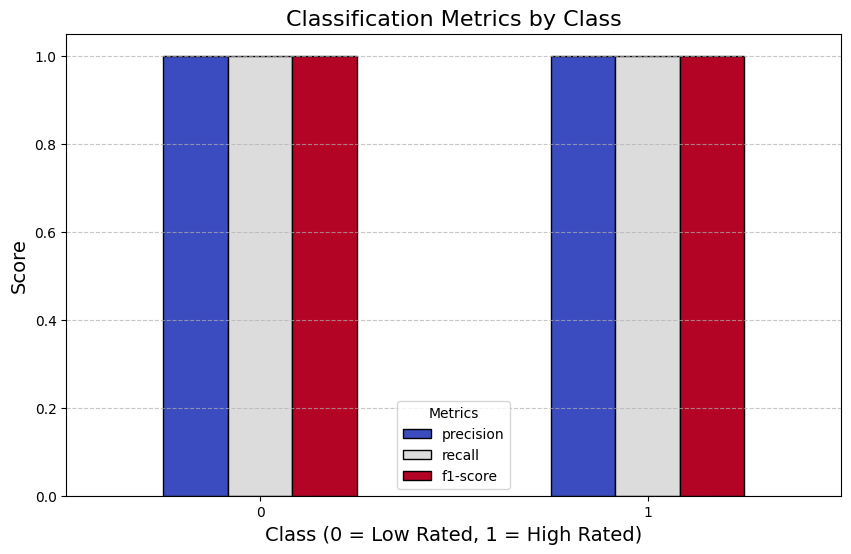

In [14]:
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report = classification_report(y_test_svm, y_pred_svm, output_dict=True)

# Convert the report into a DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Keep only the rows corresponding to '0' (Low Rated) and '1' (High Rated)
report_df_classes = report_df.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

# Plot Precision, Recall, and F1-score for each class
report_df_classes.plot(kind='bar', figsize=(10, 6), colormap='coolwarm', edgecolor='black')
plt.title("Classification Metrics by Class", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Class (0 = Low Rated, 1 = High Rated)", fontsize=14)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


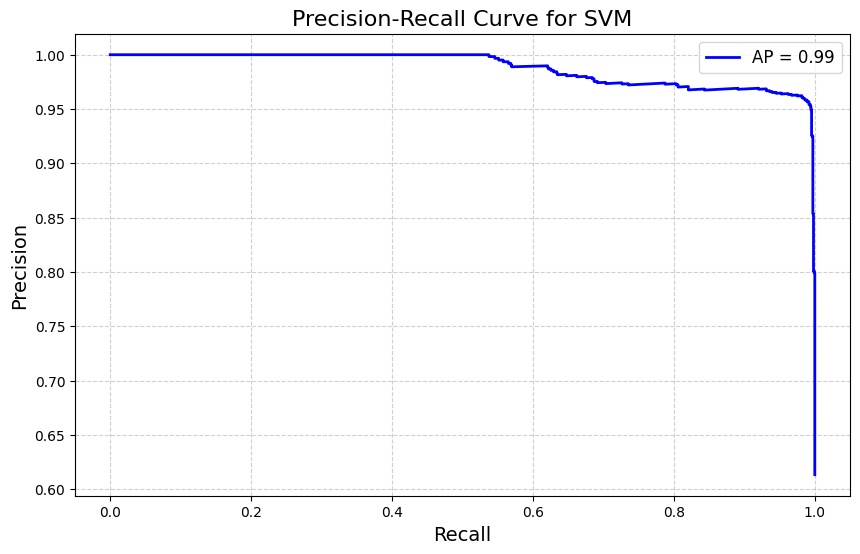

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision, recall, and thresholds for the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_svm, y_score_svm)

# Calculate the average precision score
average_precision = average_precision_score(y_test_svm, y_score_svm)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f"AP = {average_precision:.2f}")
plt.title("Precision-Recall Curve for SVM", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.show()
